In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Data Cleaning: Deduplication



In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#final=final.drop_duplicates(subset={"UserId","ProductId","Time"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [11]:
# find sentences containing HTML tags
import re

i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
import re
# nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'at', 'in', 'now', 'until', 'all', 'more', 'about', 'mightn', 'we', 'whom', 'their', "that'll", 'further', 'below', 'am', 'against', 'ourselves', 'same', 'hadn', 'his', 'by', "hadn't", 'because', "should've", 'which', 'no', 'haven', 'ours', 'did', 'isn', 'he', 'nor', 'ain', 'ma', 'you', 'my', 'for', 'out', 'who', "doesn't", 'herself', 'y', 'but', 'didn', 'from', 'should', 'him', 'yourself', 'themselves', 'such', 'shan', 'both', 'has', "mustn't", "couldn't", 'o', "won't", 'were', 'doing', 'any', 'wasn', 'a', "mightn't", 'i', 'myself', 'with', 'once', 've', 'do', 'these', 'where', 'an', 'while', 'between', 'only', 'above', 's', "isn't", 'it', "wasn't", 'each', 'will', 'have', 'to', 'some', 'me', 'weren', 'the', 'your', 'wouldn', "you'd", 'then', "you're", 'when', 'having', 'that', 'through', 'hers', 'here', 'under', "needn't", 'before', "she's", 'off', 'on', 'again', 'is', 'down', 'than', 'm', 'our', "you'll", 'they', 'so', 'into', 'as', 'yourselves', 'this', 'and', 'doesn', "it's", 'wh

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [15]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

 Bag of Words (BoW) using Brute-Force

In [16]:
final_df = pd.DataFrame(final) # storing a table in dataframe

In [17]:
random_final = final_df.sample(n=10000) # taking a sample of 10000 rows
random_final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
291682,315976,B000F9Z2BS,A134GOSQB3RDRK,valentine,1,1,positive,1221696000,Great for school lunches,I was looking for snacks to buy in bulk for sc...,b'look snack buy bulk school lunch fit bill pe...
95936,104260,B0037JAGQE,A1OAMO14MAHRM1,bryan nichols,1,1,positive,1303084800,spicy and flavorful,I have been using walkerswood jerk seasoning f...,b'use walkerswood jerk season tri make better ...
7174,7841,B00067ITNW,A2WREW7VS0GDJW,Mario M. Vittone,1,1,positive,1164931200,Perfect,This 53% percent cocoa semi-dark chocolate bar...,b'percent cocoa chocol bar perfect choic peopl...
168118,182268,B000YSXDDY,ASXJRLA0LPCSM,"Don Boynton ""Stryder""",2,2,positive,1275436800,"Sweet as honey, but without the sugar.",I love it. I am diabetic and cannot eat the re...,b'love diabet cannot eat real thing great subs...
516651,558583,B001HTL67O,A3DAJ3VYW34UB5,"Susan B. Brown ""susanakame""",0,0,positive,1349654400,Best GF Pasta,After I was diagnosed with Celiac Disease.... ...,b'diagnos celiac diseas look good pasta like u...
42499,46240,B0007G9FD0,A3MLD120JJZII5,Cat,0,0,positive,1291161600,Perfect for both overweight and healthy weight...,Our puggle's weight had ballooned to almost 40...,b'puggl weight balloon almost least pound were...
247280,268115,B001E6GFR6,A1NR6BMKPGMUVM,A. Nguyen,0,7,negative,1250640000,Not Good to Buy,"I bought 12 boxes of this kind. The word ""CAS...",b'bought box kind word cashew box promt buy bo...
18087,19708,B0030VBRIU,A3LFOYGPCS5EOA,J. McElliott,0,0,positive,1304380800,Happy Salmon Eating Baby,I was worried about it before I served it to m...,b'worri serv month old tentat first session pr...
112991,122567,B000CQBZO2,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",1,1,positive,1204761600,Quick and Easy Lunch,I bought this product for my lunch. It is real...,b'bought product lunch realli fast easi minut ...
291521,315797,B002BHSKAC,A2MWVKE1XWJEXB,No Mi,0,1,positive,1285632000,Good item,It's a good item not a miracle product but def...,b'good item miracl product definit good tast p...


In [18]:
random_final = random_final.sort_values('Time') # sort the values using Time  

In [19]:
random_final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
137935,149703,B00006L2ZT,A2Y8DAMQ4PHSK9,AWKword,2,6,positive,1036713600,Never A Dull Moment,"Finally, a collection of the best Camper Van B...",b'final collect best camper van beethoven albu...
416183,450087,B0000CH39R,A23GFTVIETX7DS,Debbie Lee Wesselmann,16,21,positive,1068249600,Excellent but not outstanding chocolates,See's Candies is a well-known San Francisco ch...,b'see candi san francisco chocol compani store...
409601,442997,B0000CNU4D,A4UKBG3M5U5TI,Westley,2,3,positive,1071360000,Fantastic Smoky Flavor,Tapatio salsa picante is one of my favorite ho...,b'tapatio salsa picant one favorit hot sauc fl...
192164,208343,B00016JH3Y,A2VZ11U5DXM8J5,"C. Ebeling ""ctlpareader""",1,2,positive,1074729600,"Best price, responsive vendor, but best product?",This is my first experience purchasing and usi...,b'first experi purchas use dri pear sinc live ...
208945,226454,B00016LA7K,A3B4P720KCGOZR,"""the_rockman""",33,33,positive,1075334400,Truly much better than bullion!,I found this product in a gourmet grocery stor...,b'found product gourmet groceri store sinc lik...
347680,376090,B0000DBN1Q,A3LFWGJ4WM0GIK,"M. A. Nelson ""cybercoyote""",6,7,positive,1080604800,Try it iced!,An incredibly refreshing drink when iced! Mix ...,b'incred refresh drink ice mix teaspoon honey ...
163209,176946,B0000CNU7C,A24Y9A3ZEV39GB,Stevie Clifton,0,0,positive,1086825600,Another recipe idea...,"As the previous poster has said, this curry is...",b'previous poster said curri beauti usual boil...
270441,293168,B0000DIYK0,A3N767A1XFAUQ2,"Fitzwilly Aircookie ""Fitzwilly Aircookie""",27,28,positive,1088208000,What don't you understand about &quot;Black Li...,"Despite the, previous, scathing review from so...",b'despit previous scath review someon even lik...
155351,168492,B0001ES9F8,A1BANTW2ZEGCI7,"""all4gizmo""",6,6,positive,1090022400,Awesome!!!,Just got my Senseo yesterday. It is the great...,b'got senseo yesterday greatest thing sinc sli...
5888,6376,B000084EKD,A1Z54EM24Y40LL,c2,1,1,negative,1090972800,Needs improved,I haven't had a cat yet that liked this one. ...,b'havent cat yet like one littl interest think...


In [20]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(random_final['CleanedText'].values)


In [21]:
type(final_counts) # type of final_counts 

scipy.sparse.csr.csr_matrix

In [22]:
final_counts.get_shape() # shape of sparse matrix

(10000, 13012)

In [23]:
# Standardizing the data with mean=0 and std.dev=1
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(final_counts)
print(standardized_data.shape)

(10000, 13012)


/home/shebu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [24]:
X = standardized_data.toarray() # storing the values after standardization in a dense array
y = np.array(random_final['Score']) # storing the values of Scores in numpy array

In [25]:
# split the data set into train and test, 70% train and 30% test 
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=0)


The optimal number of neighbors is 7.


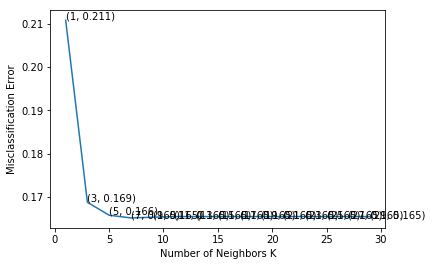

the misclassification error for each k value is :  [0.211 0.169 0.166 0.165 0.165 0.165 0.165 0.165 0.165 0.165 0.165 0.165
 0.165 0.165 0.165]


In [27]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList = list(range(0,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

ts_br = TimeSeriesSplit(n_splits=10) # split the data using TimeSeriesSplit with number of splits=10

# perform 10-fold cross validation using brute-force algorithm
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_1, y_1, cv=ts_br, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))


In [28]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 84.800000%


In [ ]:
 Bag of Words (BoW) using Kd-Tree

In [35]:
final_df1 = pd.DataFrame(final) #Table to dataframe

In [36]:
random_final1 = final_df1.sample(n=4000) # Sampling data of 4000 rows  
random_final1

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
50092,54390,B0009JRKDC,A3FU4UD3Q105YB,Crystal Wilson,0,0,positive,1343606400,I'm seriously addicted. . .,I have been using this on my skin and it's ama...,b'use skin amaz fiance constant rub skin say s...
400699,433239,B0017O3RG2,A19IYP30TM2YRV,Paul Baillargeon,0,0,positive,1336608000,Good for you.,The Turkish unsulphured apricots taste good an...,b'turkish unsulphur apricot tast good good shi...
275119,298161,B002CJAOPI,A3I8QRV4BP23CA,Soup lover,1,1,positive,1258588800,Meow,The price was right...The shipping was free......,b'price right ship free cat pleas could ask'
136867,148539,B006TACYS6,A1Z4LX3Q1YMF84,"Cindy A. Osterhout ""Cindy O""",1,1,positive,1330905600,For Mr. Picky Kitty,I have 4 Kitties and am quite accostomed to so...,b'kitti quit accostom someon turn littl pink n...
141653,153709,B0009J5RSW,AF6ONA1FDQYAL,C,0,0,positive,1200614400,Excellent! Wife now gets her calcium,I could never get my wife to take the calcium ...,b'could never get wife take calcium doctor say...
41584,45188,B005OJG45M,A1FIF1MGPVH5N4,Matty M,0,0,positive,1334534400,Better than Chocolate!,This product is amazing. The smell as soon as ...,b'product amaz smell soon bag open heaven real...
88480,96301,B000IXRFKW,A15N9FSMJ5Z1W4,llande,1,1,positive,1298937600,skor bars,too good for words. I do try to limit myself ...,b'good word tri limit one day sometim worth la...
368265,398177,B001EO5MO0,A1CXC3Z2FJBABV,Pigwit,5,5,positive,1193184000,Maple Sugar Chunks,I stumbled across the maple sugar chunks while...,b'stumbl across mapl sugar chunk look mapl pro...
4598,4993,B002Z9NKUG,A1Z4LX3Q1YMF84,"Cindy A. Osterhout ""Cindy O""",0,0,negative,1346112000,INDIGESTION OF MAJOR PROPORTIONS,I have one cat who cannot tolerate THIS PARtic...,b'one cat cannot toler particular fanci feast ...
223604,242463,B0019KPKQE,A3C5IPY55Q138V,"Jennifer Trump ""A conclusion is what we come ...",0,0,positive,1276387200,Superb for almost anything you want to season,Some seasonings are only good for some meats a...,b'season good meat veggi one use anyth strong ...


In [37]:
random_final1 = random_final1.sort_values('Time') #  Sorting the data using Time 

In [38]:
count_vect1 = CountVectorizer() #in scikit-learn
final_counts1 = count_vect1.fit_transform(random_final1['CleanedText'].values)


In [39]:
final_counts1.get_shape()

(4000, 8707)

In [40]:
# Standardizing the data with mean=0 and std.dev=1
from sklearn.preprocessing import StandardScaler
standardized_data1 = StandardScaler(with_mean=False).fit_transform(final_counts1)
print(standardized_data1.shape)

(4000, 8707)


/home/shebu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [41]:
X1 = standardized_data1.toarray() # storing the values after standardization in a dense array
y1 = np.array(random_final1['Score']) # storing the values of Scores in numpy array

In [42]:
# split the data set into train and test, 70% train and 30% test 
X_2, X_test12, y_2, y_test12 = train_test_split(X1, y1, test_size=0.3, shuffle=False, random_state=0)


The optimal number of neighbors is 5.


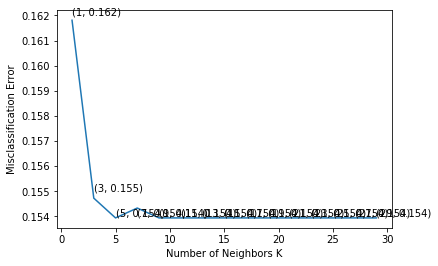

the misclassification error for each k value is :  [0.162 0.155 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.154 0.154 0.154]


In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList1 = list(range(0,30))
neighbors1 = list(filter(lambda x: x % 2 != 0, myList1))

# empty list that will hold cv scores
cv_scores_1 = []
   
t_kd = TimeSeriesSplit(n_splits=10)

# perform 10-fold cross validation using kd-tree algorithm
for k in neighbors1:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores_1 = cross_val_score(knn, X_2, y_2, cv=t_kd, scoring='accuracy')
    cv_scores_1.append(scores_1.mean())

# changing to misclassification error
MSE_1 = [1 - x for x in cv_scores_1]

# determining best k
optimal_k_1 = neighbors1[MSE_1.index(min(MSE_1))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_1)

# plot misclassification error vs k 
plt.plot(neighbors1, MSE_1)

for xy in zip(neighbors1, np.round(MSE_1,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_1,3))


In [44]:
# instantiate learning model k = optimal_k
knn_optimal_1 = KNeighborsClassifier(n_neighbors=optimal_k_1)

# fitting the model
knn_optimal_1.fit(X_2, y_2)

# predict the response
pred_1 = knn_optimal_1.predict(X_test12)

# evaluate accuracy
acc_1 = accuracy_score(y_test12, pred_1) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_1, acc_1))


The accuracy of the knn classifier for k = 5 is 83.666667%


 TF-IDF for K-NN with Brute-Force

In [46]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(random_final['CleanedText'].values)


In [47]:
final_tf_idf.get_shape()


(10000, 235211)

In [48]:
features = tf_idf_vect.get_feature_names()
len(features)


235211

In [55]:
# Standardizing the data with mean=0 and std.dev=1
from sklearn.preprocessing import StandardScaler
standardized_data_tf_idf = StandardScaler(with_mean=False).fit_transform(final_tf_idf)
print(standardized_data_tf_idf.shape)

(10000, 235211)


In [57]:
X_tf = np.array(standardized_data_tf_idf) # storing the values after standardization in a dense array
y_tf = np.array(random_final['Score']) # storing the values of Scores in numpy array

In [ ]:
# split the data set into train and test, 70% train and 30% test 
X_1_tf, X_test_tf, y_1_tf, y_test_tf = train_test_split(X_tf, y_tf, test_size=0.3, shuffle=False, random_state=0)


The optimal number of neighbors is 23.


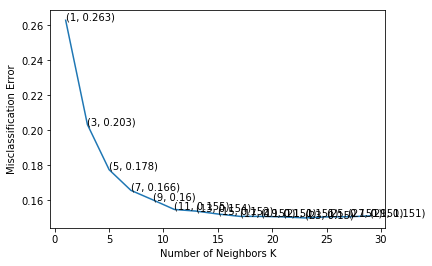

the misclassification error for each k value is :  [0.263 0.203 0.178 0.166 0.16  0.155 0.154 0.152 0.151 0.151 0.151 0.15
 0.151 0.151 0.151]


In [105]:
from sklearn.model_selection import TimeSeriesSplit


# creating odd list of K for KNN
myList2 = list(range(0,30))
neighbors2 = list(filter(lambda x: x % 2 != 0, myList2))

# empty list that will hold cv scores
cv_scores_2 = []
   
tf_br = TimeSeriesSplit(n_splits=10)    
    
 # perform 10-fold cross validation using brute force 
for k in neighbors2:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores_2 = cross_val_score(knn, X_1_tf, y_1_tf, cv=tf_br, scoring='accuracy')
    cv_scores_2.append(scores_2.mean())

# changing to misclassification error
MSE_2 = [1 - x for x in cv_scores_2]

# determining best k
optimal_k_tf = neighbors2[MSE_2.index(min(MSE_2))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tf)

# plot misclassification error vs k 
plt.plot(neighbors2, MSE_2)

for xy in zip(neighbors2, np.round(MSE_2,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_2,3))


In [106]:
# instantiate learning model k = optimal_k
knn_optimal_tf = KNeighborsClassifier(n_neighbors=optimal_k_tf)

# fitting the model
knn_optimal_tf.fit(X_1_tf, y_1_tf)

# predict the response
pred_tf = knn_optimal_tf.predict(X_test_tf)

# evaluate accuracy
acc_tf = accuracy_score(y_test_tf, pred_tf) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tf, acc_tf))


The accuracy of the knn classifier for k = 23 is 84.658333%


In [29]:
final_df_tf = pd.DataFrame(final) # Converting the table to dataframe

In [30]:
random_final_tf = final_df_tf.sample(n=4000) # Sampling 4000 rows
random_final_tf

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
71740,78106,B0011664YS,A2R7TORB7KSUIJ,Robert W. Ritchey,0,0,positive,1338508800,Good deal better than more expensive brands.,Title says it all. Bought as a gift to someon...,b'titl say bought gift someon like chocol cove...
215613,233673,B003VZCYHI,A1TD2589ZVHZ3S,Terry,1,2,positive,1313366400,GREAT with or without milk!,"I bought these because they were on sale, and ...",b'bought sale glad great milk breakfast even b...
307561,333091,B000EA0D1C,A2FU9K67LZE250,Marie Clement,0,0,positive,1255392000,Wholesome sweeteners Fair Trade Organic Dark b...,"This sugar has replaced my ""white"" sugar. It i...",b'sugar replac white sugar sticki clog transfe...
96236,104579,B004MFWJ94,A20Q50N2UYR5JD,JenK in Seattle,0,0,positive,1326844800,Good hot chocolate substitute,I have been on a hot chocolate kick since the ...,b'hot chocol kick sinc holiday caffein habit d...
198201,214806,B001BBXP7M,AO09U2GGNUJG6,A. E Heald,0,0,positive,1231804800,Sugar-Free Aftertast but Good Results,"It's not the best tasting vitamin drink, I'm s...",b'best tast vitamin drink sure dont buy vitami...
405159,438135,B00015UC4S,A31LA2BD72ITF7,Harley7707,4,4,positive,1266105600,Just what we were hoping for,Could not find clear jel for canning anywhere ...,b'could find clear jel canning anywher local p...
31535,34339,B001P3NU30,A1E0L5SY948J2U,"Charles Ciccone ""charles""",2,3,positive,1301529600,Nice Teeth!,"Great to keep my Bostons teeth clean, Watch ou...",b'great keep boston teeth clean watch choke al...
508138,549464,B004054PUM,AZJ2OF5TAF2RH,"J. Rust ""Rusty""",2,3,negative,1304035200,Read the fine print,This product is definitely not as advertised o...,b'product definit advertis pictur photo clear ...
153485,166420,B000IMSSHM,A1KY6V7MET7WQJ,brycesmom,2,2,positive,1296172800,cinnamon chips,"These chips are impossible to find, at least i...",b'chip imposs find least calif howev cooki rec...
194370,210717,B001EQ4OWO,A374O3186D2HTX,"Kat ""doglover""",42,42,negative,1302652800,i used to love these bags,i first found out about these bags several yea...,b'first found bag sever year back found avail ...


In [31]:
random_final_tf = random_final_tf.sort_values('Time') # Sorting based on timestamp

In [ ]:
 TF-IDF for K-NN with KD-Tree

In [32]:
tf_idf_vect_kd = TfidfVectorizer(ngram_range=(1,2)) # using bi-gram
final_tf_idf_kd = tf_idf_vect_kd.fit_transform(random_final_tf['CleanedText'].values)


In [33]:
final_tf_idf_kd.get_shape()


(4000, 111258)

In [35]:
# Standardizing data with mean=0 and variance = 1
from sklearn.preprocessing import StandardScaler
standardized_data_tf_idf_kd = StandardScaler(with_mean=False).fit_transform(final_tf_idf_kd)
print(standardized_data_tf_idf_kd.shape)

(4000, 111258)


In [36]:
X_tf_kd = standardized_data_tf_idf_kd.toarray() # storing the values after standardization in a dense array
y_tf_kd = np.array(random_final_tf['Score'])  # storing the values of Scores in numpy array

In [37]:
# split the data set into train and test, 70% train and 30% test 
X_1_tf_kd, X_test_tf_kd, y_1_tf_kd, y_test_tf_kd = train_test_split(X_tf_kd, y_tf_kd, test_size=0.3, shuffle=False, random_state=0)


The optimal number of neighbors is 3.


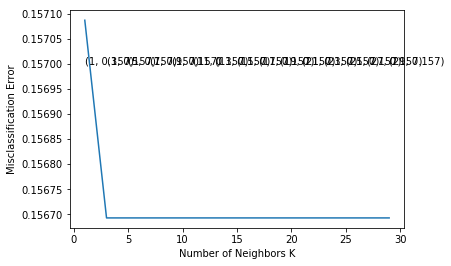

the misclassification error for each k value is :  [0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157
 0.157 0.157 0.157]


In [38]:
from sklearn.model_selection import TimeSeriesSplit


# creating odd list of K for KNN
myList2_kd = list(range(0,30))
neighbors2_kd = list(filter(lambda x: x % 2 != 0, myList2_kd))

# empty list that will hold cv scores
cv_scores_2_kd = []
   
    
ti_kd = TimeSeriesSplit(n_splits=10) # TimeBased Slicing with 10 fold Cross-Validation

 # perform 10-fold cross validation using kd-tree
for k in neighbors2_kd:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores_2_kd = cross_val_score(knn, X_1_tf_kd, y_1_tf_kd, cv=ti_kd, scoring='accuracy')
    cv_scores_2_kd.append(scores_2_kd.mean())

# changing to misclassification error
MSE_2_kd = [1 - x for x in cv_scores_2_kd]

# determining best k
optimal_k_tf_kd = neighbors2_kd[MSE_2_kd.index(min(MSE_2_kd))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_tf_kd)

# plot misclassification error vs k 
plt.plot(neighbors2_kd, MSE_2_kd)

for xy in zip(neighbors2_kd, np.round(MSE_2_kd,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_2_kd,3))


In [39]:
# instantiate learning model k = optimal_k
knn_optimal_tf_kd = KNeighborsClassifier(n_neighbors=optimal_k_tf_kd)

# fitting the model
knn_optimal_tf_kd.fit(X_1_tf_kd, y_1_tf_kd)

# predict the response
pred_tf_kd = knn_optimal_tf_kd.predict(X_test_tf_kd)

# evaluate accuracy
acc_tf_kd = accuracy_score(y_test_tf_kd, pred_tf_kd) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_tf_kd, acc_tf_kd))


The accuracy of the knn classifier for k = 3 is 84.000000%


In [58]:
# Training Word2Vec using our corpus 
import gensim
i=0
list_of_sent=[]
for sent in random_final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [59]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=6)    


Average-w2v on K-NN with Brute Force

In [60]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

10000
50


In [61]:
df_w2v = pd.DataFrame(sent_vectors) # storing average w2vec in a dataframe 

In [62]:
df_w2v.isnull().any() # Check whether if there is any Nan value

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [63]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v = StandardScaler().fit_transform(df_w2v)
print(standardized_data_av_w2v.shape)

(10000, 50)


In [64]:
X_w2v = np.array(standardized_data_av_w2v) # Storing the value of standardized data in a numpy array
y_w2v = np.array(random_final['Score']) # Storing the value of reviews i.e. positive and negative in a numpy array

In [65]:
# split the data set into train and test in 70% train and 30% test
X_1_w2v, X_test_w2v, y_1_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.3, shuffle=False, random_state=0)


The optimal number of neighbors is 23.


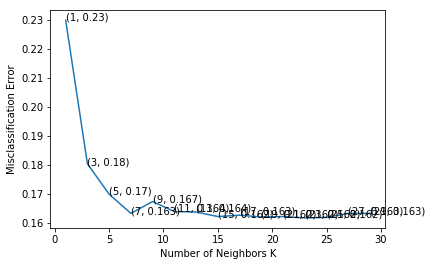

the misclassification error for each k value is :  [0.23  0.18  0.17  0.163 0.167 0.164 0.164 0.162 0.163 0.162 0.162 0.162
 0.162 0.163 0.163]


In [66]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList_w2v = list(range(0,30))
neighbors_w2v = list(filter(lambda x: x % 2 != 0, myList_w2v))

# empty list that will hold cv scores
cv_scores_w2v = []

av_br = TimeSeriesSplit(n_splits=10) # TimeSeries Split in 10-fold cross-validation
   
 # perform 10-fold cross validation with algorithm = brute-force
for k in neighbors_w2v:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores_w2v = cross_val_score(knn, X_1_w2v, y_1_w2v, cv=av_br, scoring='accuracy')
    cv_scores_w2v.append(scores_w2v.mean())

# changing to misclassification error
MSE_w2v = [1 - x for x in cv_scores_w2v]

# determining best k
optimal_k_w2v = neighbors_w2v[MSE_w2v.index(min(MSE_w2v))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_w2v)

# plot misclassification error vs k 
plt.plot(neighbors_w2v, MSE_w2v)

for xy in zip(neighbors_w2v, np.round(MSE_w2v,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_w2v,3))


In [67]:
# instantiate learning model k = optimal_k
knn_optimal_w2v = KNeighborsClassifier(n_neighbors=optimal_k_w2v)

# fitting the model
knn_optimal_w2v.fit(X_1_w2v, y_1_w2v)

# predict the response
pred_w2v = knn_optimal_w2v.predict(X_test_w2v)

# evaluate accuracy
acc_w2v = accuracy_score(y_test_w2v, pred_w2v) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_w2v, acc_w2v))


The accuracy of the knn classifier for k = 23 is 85.400000%


In [ ]:
Average-w2v on K-NN with Kd-Tree

In [68]:
# Training Word2Vec using our corpus
import gensim
i=0
list_of_sent1=[]
for sent in random_final1['Text'].values:
    filtered_sentence1=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    # checking is the word is alphabet
                filtered_sentence1.append(cleaned_words.lower()) # appending to the list
            else:
                continue 
    list_of_sent1.append(filtered_sentence)
    

In [69]:
w2v_model1=gensim.models.Word2Vec(list_of_sent1,min_count=5,size=50, workers=6)    


In [70]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent1: # for each review/sentence
    sent_vec1 = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model1.wv[word]
            sent_vec1 += vec
            cnt_words += 1
        except:
            pass
    sent_vec1 /= cnt_words
    sent_vectors1.append(sent_vec1)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

4000
50


In [71]:
df_w2v_kd = pd.DataFrame(sent_vectors1) # storing average w2vec in a dataframe 

In [72]:
df_w2v.isnull().any() # Check whether if there is any Nan value

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool

In [73]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v_kd = StandardScaler().fit_transform(df_w2v_kd)
print(standardized_data_av_w2v_kd.shape)

(4000, 50)


In [74]:
X_w2v_kd = np.array(standardized_data_av_w2v_kd) # Storing the value of standardized data in a numpy array
y_w2v_kd = np.array(random_final1['Score']) # Storing the value of reviews i.e. positive and negative in a numpy array

In [75]:
# split the data set into train and test in 70% train and 30% test
X_1_w2v_kd, X_test_w2v_kd, y_1_w2v_kd, y_test_w2v_kd = train_test_split(X_w2v_kd, y_w2v_kd, test_size=0.3, shuffle=False, random_state=0)


The optimal number of neighbors is 3.


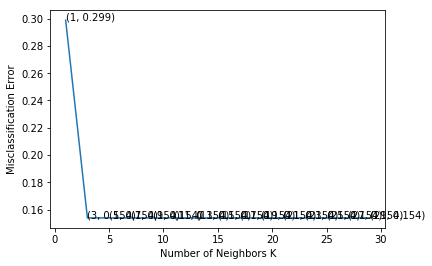

the misclassification error for each k value is :  [0.299 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.154 0.154 0.154]


In [76]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList_w2v_kd = list(range(0,30))
neighbors_w2v_kd = list(filter(lambda x: x % 2 != 0, myList_w2v_kd))

# empty list that will hold cv scores
cv_scores_w2v_kd = []

av_kd = TimeSeriesSplit(n_splits=10) # TimeSeries Split in 10-fold cross-validation
   
 # perform 10-fold cross validation using algorithm=kd-tree
for k in neighbors_w2v_kd:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores_w2v_kd = cross_val_score(knn, X_1_w2v_kd, y_1_w2v_kd, cv=av_kd, scoring='accuracy')
    cv_scores_w2v_kd.append(scores_w2v_kd.mean())

# changing to misclassification error
MSE_w2v_kd = [1 - x for x in cv_scores_w2v_kd]

# determining best k
optimal_k_w2v_kd = neighbors_w2v_kd[MSE_w2v_kd.index(min(MSE_w2v_kd))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_w2v_kd)

# plot misclassification error vs k 
plt.plot(neighbors_w2v_kd, MSE_w2v_kd)

for xy in zip(neighbors_w2v_kd, np.round(MSE_w2v_kd,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_w2v_kd,3))


In [77]:
# instantiate learning model k = optimal_k
knn_optimal_w2v_kd = KNeighborsClassifier(n_neighbors=optimal_k_w2v_kd)

# fitting the model
knn_optimal_w2v_kd.fit(X_1_w2v_kd, y_1_w2v_kd)

# predict the response
pred_w2v_kd = knn_optimal_w2v_kd.predict(X_test_w2v_kd)

# evaluate accuracy
acc_w2v_kd = accuracy_score(y_test_w2v_kd, pred_w2v_kd) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_w2v_kd, acc_w2v_kd))


The accuracy of the knn classifier for k = 3 is 83.666667%


In [ ]:
Tf_Idf-w2v on K-NN with Brute force

In [78]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

/home/shebu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


10000
50


In [79]:
df_w2v_tf = pd.DataFrame(tfidf_sent_vectors) # storing average w2vec in a dataframe 

In [80]:
df_w2v_tf.isnull().any() # Check whether if there is any Nan value

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
46    True
47    True
48    True
49    True
dtype: bool

In [81]:
df_w2v_tf = df_w2v_tf.fillna(0) #filling the dataframe with 0 if there is any Nan entry

In [82]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_av_w2v_tf = StandardScaler().fit_transform(df_w2v_tf)
print(standardized_data_av_w2v_tf.shape)

(10000, 50)


In [83]:
X_w2v_tf = np.array(standardized_data_av_w2v_tf) # Storing the value of standardized data in a numpy array
y_w2v_tf = np.array(random_final['Score']) # Storing the value of reviews i.e. positive and negative in a numpy array

In [84]:
# split the data set into train and test in 70% train and 30% test
X_1_w2v_tf, X_test_w2v_tf, y_1_w2v_tf, y_test_w2v_tf = train_test_split(X_w2v_tf, y_w2v_tf, test_size=0.3, shuffle=False, random_state=0)


The optimal number of neighbors is 1.


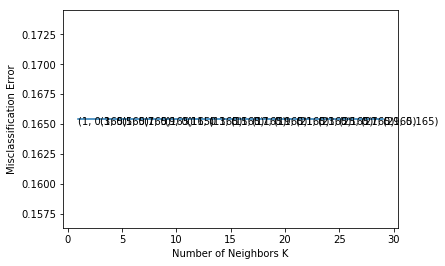

the misclassification error for each k value is :  [0.165 0.165 0.165 0.165 0.165 0.165 0.165 0.165 0.165 0.165 0.165 0.165
 0.165 0.165 0.165]


In [85]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList_w2v_tf = list(range(0,30))
neighbors_w2v_tf = list(filter(lambda x: x % 2 != 0, myList_w2v_tf))

# empty list that will hold cv scores
cv_scores_w2v_tf = []

av_br_tf = TimeSeriesSplit(n_splits=10) # TimeSeries Split in 10-fold cross-validation
   
 # perform 10-fold cross validation using brute force
for k in neighbors_w2v_tf:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores_w2v_tf = cross_val_score(knn, X_1_w2v_tf, y_1_w2v_tf, cv=av_br_tf, scoring='accuracy')
    cv_scores_w2v_tf.append(scores_w2v_tf.mean())

# changing to misclassification error
MSE_w2v_tf = [1 - x for x in cv_scores_w2v_tf]

# determining best k
optimal_k_w2v_tf = neighbors_w2v_tf[MSE_w2v_tf.index(min(MSE_w2v_tf))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_w2v_tf)

# plot misclassification error vs k 
plt.plot(neighbors_w2v_tf, MSE_w2v_tf)

for xy in zip(neighbors_w2v_tf, np.round(MSE_w2v_tf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_w2v_tf,3))


In [84]:
# instantiate learning model k = optimal_k
knn_optimal_w2v_tf = KNeighborsClassifier(n_neighbors=optimal_k_w2v_tf)

# fitting the model
knn_optimal_w2v_tf.fit(X_1_w2v_tf, y_1_w2v_tf)

# predict the response
pred_w2v_tf = knn_optimal_w2v_tf.predict(X_test_w2v_tf)

# evaluate accuracy
acc_w2v_tf = accuracy_score(y_test_w2v_tf, pred_w2v_tf) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_w2v_tf, acc_w2v_tf))


The accuracy of the knn classifier for k = 1 is 84.291667%


In [ ]:
Tf_Idf-w2v on K-NN with Kd-Tree

In [95]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent1: # for each review/sentence
    sent_vec1 = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec1 = w2v_model1.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec1 += (vec1 * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec1 /= weight_sum
    tfidf_sent_vectors1.append(sent_vec1)
    row += 1
    
print(len(tfidf_sent_vectors1))
print(len(tfidf_sent_vectors1[0]))

/home/shebu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


4000
50


In [96]:
df_w2v_kd_tf = pd.DataFrame(tfidf_sent_vectors1) # storing average w2vec in a dataframe 

In [97]:
df_w2v_kd_tf.isnull().any()  # Check whether if there is any Nan value

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
46    True
47    True
48    True
49    True
dtype: bool

In [98]:
df_w2v_kd_tf = df_w2v_kd_tf.fillna(0)  #filling the dataframe with 0 if there is any Nan entry

In [99]:
''' 
standardizing the data with mean = 0 and standard deviation = 1
'''

from sklearn.preprocessing import StandardScaler
standardized_data_w2v_kd_tf = StandardScaler().fit_transform(df_w2v_kd_tf)
print(standardized_data_w2v_kd_tf.shape)

(4000, 50)


In [100]:
X_w2v_kd_tf = np.array(standardized_data_w2v_kd_tf) # Storing the value of standardized data in a numpy array
y_w2v_kd_tf = np.array(random_final1['Score']) # Storing the value of reviews i.e. positive and negative in a nump array

In [101]:
# split the data set into train and test in 70% train and 30% test
X_1_w2v_kd_tf, X_test_w2v_kd_tf, y_1_w2v_kd_tf, y_test_w2v_kd_tf = train_test_split(X_w2v_kd_tf, y_w2v_kd_tf, test_size=0.3, shuffle=False, random_state=0)


The optimal number of neighbors is 3.


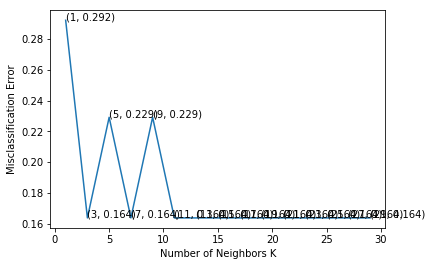

the misclassification error for each k value is :  [0.292 0.164 0.229 0.164 0.229 0.164 0.164 0.164 0.164 0.164 0.164 0.164
 0.164 0.164 0.164]


In [104]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList_w2v_kd_tf = list(range(0,30))
neighbors_w2v_kd_tf = list(filter(lambda x: x % 2 != 0, myList_w2v_kd_tf))

# empty list that will hold cv scores
cv_scores_w2v_kd_tf = []

av_kd_tf = TimeSeriesSplit(n_splits=10) # Time based slicing with number of splits=10
   
 # perform 10-fold cross validation and algorithm=kd-tree
for k in neighbors_w2v_kd_tf:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores_w2v_kd_tf = cross_val_score(knn, X_1_w2v_kd_tf, y_1_w2v_kd_tf, cv=av_kd_tf, scoring='accuracy')
    cv_scores_w2v_kd_tf.append(scores_w2v_kd_tf.mean())

# changing to misclassification error
MSE_w2v_kd_tf = [1 - x for x in cv_scores_w2v_kd_tf]

# determining best k
optimal_k_w2v_kd_tf = neighbors_w2v_kd_tf[MSE_w2v_kd_tf.index(min(MSE_w2v_kd_tf))]
print('\nThe optimal number of neighbors is %d.' % optimal_k_w2v_kd_tf)

# plot misclassification error vs k 
plt.plot(neighbors_w2v_kd_tf, MSE_w2v_kd_tf)

for xy in zip(neighbors_w2v_kd_tf, np.round(MSE_w2v_kd_tf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE_w2v_kd_tf,3))


In [105]:
# instantiate learning model k = optimal_k
knn_optimal_w2v_kd_tf = KNeighborsClassifier(n_neighbors=optimal_k_w2v_kd_tf)

# fitting the model
knn_optimal_w2v_kd_tf.fit(X_1_w2v_kd_tf, y_1_w2v_kd_tf)

# predict the response
pred_w2v_kd_tf = knn_optimal_w2v_kd_tf.predict(X_test_w2v_kd_tf)

# evaluate accuracy
acc_w2v_kd_tf = accuracy_score(y_test_w2v_kd_tf, pred_w2v_kd_tf) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_w2v_kd_tf, acc_w2v_kd_tf))


The accuracy of the knn classifier for k = 3 is 84.416667%
